In [1]:
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd

adata = sc.read_h5ad("combined.h5ad")
adata

/home/aniruddham/code/covid-lung-atlas/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 85361 × 12892
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [2]:
adata.obs.groupby("Sample").count()  # type: ignore

/tmp/ipykernel_3888328/1246531493.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("Sample").count()  # type: ignore


,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
C51ctr,4620,4620,4620,4620,4620,4620,4620,4620
C52ctr,3457,3457,3457,3457,3457,3457,3457,3457
C53ctr,5639,5639,5639,5639,5639,5639,5639,5639
C54ctr,3624,3624,3624,3624,3624,3624,3624,3624
C55ctr,4590,4590,4590,4590,4590,4590,4590,4590
C56ctr,3089,3089,3089,3089,3089,3089,3089,3089
C57ctr,3836,3836,3836,3836,3836,3836,3836,3836
L01cov,2345,2345,2345,2345,2345,2345,2345,2345
L03cov,2757,2757,2757,2757,2757,2757,2757,2757


In [3]:
# we save the unnormalized data to the "counts" layer
adata.layers["counts"] = adata.X.copy()  # type: ignore
# and the proceed to normalize and log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [4]:
adata.obs.head()  # type: ignore

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TGAATCGCAACGTAAA-1_9,L03cov,False,3377,3373,10921.0,14.0,0.128193,61.0,0.558557
TGACGCGAGGCATCTT-1_9,L03cov,False,3195,3185,10427.0,0.0,0.000000,1.0,0.009590
GGCTTGGTCGGACCAC-1_9,L03cov,False,3261,3253,10297.0,1.0,0.009712,41.0,0.398174
TAGACCACAGAACCGA-1_9,L03cov,False,3430,3425,9691.0,0.0,0.000000,20.0,0.206377
AGACTCAGTGCTGCAC-1_9,L03cov,False,3394,3387,9428.0,5.0,0.053034,4.0,0.042427


In [5]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["Sample"],
    continuous_covariate_keys=["pct_counts_mt", "total_counts", "pct_counts_ribo"],
)


In [6]:
model = scvi.model.SCVI(adata)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aniruddham/code/covid-lung-atlas/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/aniruddham/c

Epoch 94/94: 100%|██████████| 94/94 [07:16<00:00,  4.73s/it, v_num=1, train_loss=2.37e+3]

`Trainer.fit` stopped: `max_epochs=94` reached.


Epoch 94/94: 100%|██████████| 94/94 [07:16<00:00,  4.65s/it, v_num=1, train_loss=2.37e+3]


In [14]:
model.save("model")

In [7]:
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

/tmp/ipykernel_3888328/3796454756.py:3: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=0.5)


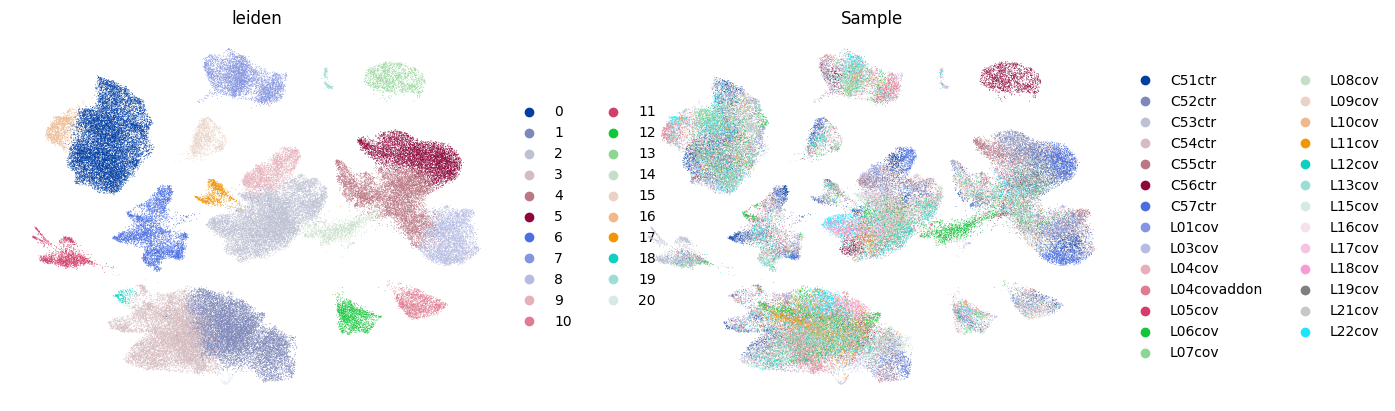

In [11]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden", "Sample"], frameon=False)

In [12]:
adata.write_h5ad("integrated.h5ad")